# Data Analysis of Job tasks
When taking into account the occupation and when not taking into account the occupation, using machine learning methods such as text clustering and tokenization

Name: Joshua Hizgiaev<br>
Research: SIAI

In [1]:
!pip install nltk
!pip install transformers
!pip install seaborn
!pip install pandas numpy scipy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [3]:
# Add standard data science pacakges
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load google drive with excel sheet
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load excel sheet data into google colab
path = '/content/drive/MyDrive/Data/Task Statements.xlsx'
task_excel = pd.DataFrame(pd.read_excel(path))
task_csv = task_excel.to_csv("/content/drive/MyDrive/Data/Task_Statements.csv",index=None,header=True)
df = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Data/Task_Statements.csv"))
print(df.shape[0])
df.head()

19265


,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,87.0,07/2014,Incumbent
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assig...,Core,87.0,07/2014,Incumbent
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,87.0,07/2014,Incumbent
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,87.0,07/2014,Incumbent
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,87.0,07/2014,Incumbent


# Preprocessing:
1. Getting rid of unneeded columns
2. Getting rid of duplicates if any
3. Getting rid of missing values if any 
4. Convert dates to date time python objects

In [6]:
df = df.drop(['O*NET-SOC Code','Task ID','Domain Source'],axis=1).drop_duplicates().dropna(how='all')
df['Date'] = pd.to_datetime(df.Date,format='%m/%Y')
df['Date'] = df['Date'].dt.strftime('%m-%Y')
print(df.shape[0])
df.head()

19265


,Title,Task,Task Type,Incumbents Responding,Date
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014


In [7]:
# Find the total amount of tasks that are core, supplemental, or neither
# this will help in understanding how the data was made, as well as what majority of the data is place or 
# if it is evenly distributed
core_df = df[df['Task Type'] == 'Core']
supp_df = df[df['Task Type'] == 'Supplemental']
neither_df = df[df['Task Type'].isna()]
print("The number of tasks identified as core: {}".format(core_df.shape[0]))
print("The number of tasks identified as supplemental: {}".format(supp_df.shape[0]))
print("The number of tasks identified as neither core or supplemental: {}".format(neither_df.shape[0]))
core_df.reset_index(drop=True, inplace=True)
supp_df.reset_index(drop=True, inplace=True)
neither_df.reset_index(drop=True, inplace=True)

The number of tasks identified as core: 13225
The number of tasks identified as supplemental: 4728
The number of tasks identified as neither core or supplemental: 1312


### It is clear that there is an uneven number of core, supplemental, and tasks classified as neither
I now need to determine how exactly I should utilize this data, and how to approach it with NLP. I will first begin with **NOT** concidering occupation, meaning that I will only need to perform similarity clustering for tasks only. With that decided, I will perform NLP with the following data:
1. The data as a whole
2. The data of supplemental tasks
3. The data of core tasks
4. The data of tasks classified as neither (not core or supplemental basically)

To do so, I need to develop a Natural Language Processing model with pytorch that will allow me to create clusters based on the similarity of tasks and apply a label to each task. Meaning I will group tasks based on their similarity by assigning a numerical label to each task, every task with the same label will be in the same cluster!

In [8]:
# preprocess text data for NLP, I will begin with taking into 
# account the WHOLE dataset, and then will work on core, supplemental, and neither later
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

X = df['Task'].tolist()

documents = []
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
for sen in range(0,len(X)):
  # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

df['Processed Tasks'] = np.array(documents)
df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014,direct or coordinate an organization financial...
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014,appoint department head or manager and assign ...
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014,analyze operation to evaluate performance of c...
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014,direct plan or implement policy objective or a...
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014,prepare budget for approval including those fo...
...,...,...,...,...,...,...
19260,"Tank Car, Truck, and Ship Loaders",Unload cars containing liquids by connecting h...,Supplemental,85.0,08-2019,unload car containing liquid by connecting hos...
19261,"Tank Car, Truck, and Ship Loaders","Clean interiors of tank cars or tank trucks, u...",Supplemental,85.0,08-2019,clean interior of tank car or tank truck using...
19262,"Tank Car, Truck, and Ship Loaders",Lower gauge rods into tanks or read meters to ...,Supplemental,85.0,08-2019,lower gauge rod into tank or read meter to ver...
19263,"Tank Car, Truck, and Ship Loaders",Operate conveyors and equipment to transfer gr...,Supplemental,85.0,08-2019,operate conveyor and equipment to transfer gra...


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.decomposition import PCA


vectorizer = TfidfVectorizer()
processed_text = df['Processed Tasks'].tolist()
X = vectorizer.fit_transform(processed_text)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

k = 21
kmeans = KMeans(n_clusters = k,init='k-means++',max_iter=300,n_init=15, random_state=42)
kmeans.fit(X_pca)
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("The average silhouette_score is :", silhouette_avg)
df['Labels'] = kmeans.labels_
clusters = kmeans.labels_.tolist()
texts_df = pd.DataFrame({'text':processed_text,'cluster':clusters})
texts_df

The average silhouette_score is : -0.005147136282051376


,text,cluster
0,direct or coordinate an organization financial...,15
1,appoint department head or manager and assign ...,14
2,analyze operation to evaluate performance of c...,15
3,direct plan or implement policy objective or a...,15
4,prepare budget for approval including those fo...,0
...,...,...
19260,unload car containing liquid by connecting hos...,18
19261,clean interior of tank car or tank truck using...,12
19262,lower gauge rod into tank or read meter to ver...,18
19263,operate conveyor and equipment to transfer gra...,19


In [10]:
texts_df.to_excel('/content/drive/MyDrive/Data/output.xlsx')
X_pca.shape

(19265, 2)

In [11]:
%matplotlib inline

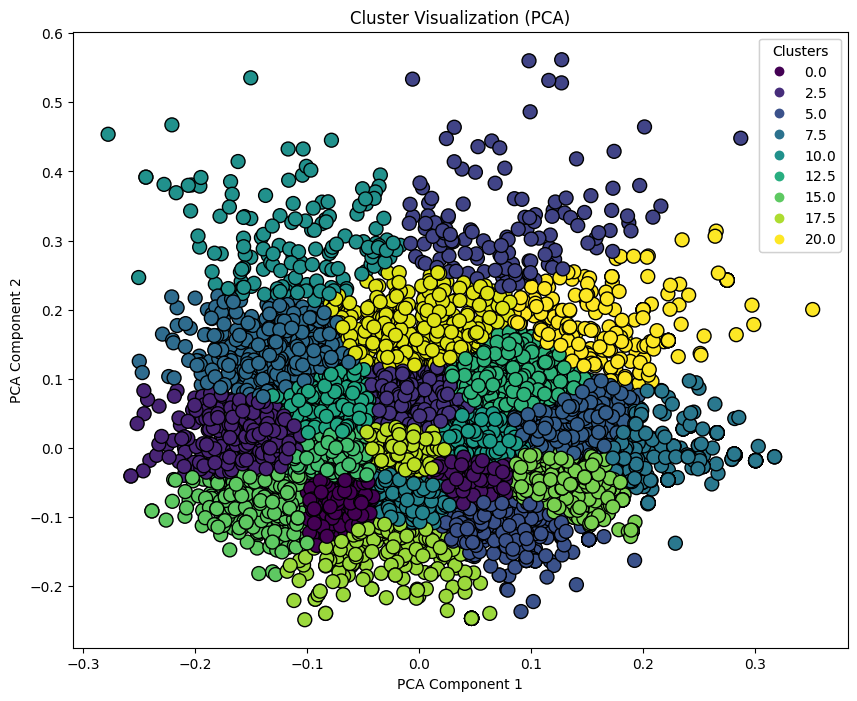

In [12]:
pca_df = pd.DataFrame(data=X_pca, columns=["PCA1", "PCA2"])
pca_df["cluster"] = clusters
plt.figure(figsize=(10, 8))
ax = plt.gca()
scatter = ax.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["cluster"], cmap="viridis", edgecolors='k', s=100)
legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
ax.add_artist(legend1)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization (PCA)")
plt.show()

### Now that task statements are assigned cluster labels I now want to do text classification to appoint every task description one of the following categories:

1. Technical/Engineering: Tasks involving designing, testing, and installation of devices, software, or complex equipment.

2. Management/Leadership: Tasks related to directing, overseeing, and organizing teams, projects, or departments.

3. Administrative: Tasks associated with scheduling, record-keeping, data entry, and reporting.

4. Marketing/Sales: Tasks related to promoting, selling, and creating demand for products or services.

5. Customer Service: Tasks involving interacting with customers, resolving concerns, and providing support.

6. Research/Analysis: Tasks related to gathering information, conducting studies, and evaluating findings.

7. Production: Tasks focused on manufacturing, assembly, and operations of products or machines.

8. Quality Assurance/Control: Tasks related to ensuring quality, adherence to standards, and improvement activities.

9. Human Resources: Tasks dealing with recruitment, hiring, employee relations, and training.

10. Finance/Accounting: Tasks focused on financial management, budgeting, and revenues.

11. Information Technology: Tasks associated with managing and maintaining digital systems, networks, and databases.

12. Maintenance/Repair: Tasks involving the upkeep and repair of equipment, buildings, or machinery.

13. Logistics/Supply chain: Tasks related to managing inventory, transportation, and distribution.

14. Creative/Design: Tasks involving design, creation, and innovation in various fields such as art, graphics, or products.

15. Education/Training: Tasks focused on teaching, mentoring, and skill development.

16. Health/Medical: Tasks related to patient care, treatment, and medical procedures.

17. Legal/Compliance: Tasks associated with ensuring adherence to laws and regulations.

18. Project Management: Tasks focused on planning, execution, and delivery of projects.

19. Security/Safety: Tasks related to the protection of people, property, or information.

20. Environment/Sustainability: Tasks focused on conservation, waste management, and eco-friendly processes.

# How does one do this?

Well I have the cluster labels, all I really need to do is go through the data and place the labels myself!

In [13]:
!nvidia-smi

Mon Jun 12 02:15:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
from transformers import pipeline

categories = [
    "Technical/Engineering", "Management/Leadership", "Administrative",
    "Marketing/Sales", "Customer Service", "Research", "Production",
    "Quality Assurance/Control", "Human Resources", "Finance/Accounting",
    "Information Technology", "Maintenance/Repair", "Logistics/Supply chain",
    "Creative/Design", "Education/Training", "Health/Medical",
    "Legal/Compliance", "Project Management", "Security/Safety",
    "Environment/Sustainability", "Data Science/Analysis"
]

nlp = pipeline("zero-shot-classification", device=0)
# Function to categorize descriptions
def categorize_description(description: str) -> str:
    result = nlp(description, categories,multi_label=False)
    return result["labels"][0]
df["category"] = df["Processed Tasks"].apply(categorize_description)
df.to_excel('/content/drive/MyDrive/Data/category_output.xlsx')
df

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks,Labels,category
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014,direct or coordinate an organization financial...,15,Management/Leadership
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014,appoint department head or manager and assign ...,14,Management/Leadership
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014,analyze operation to evaluate performance of c...,15,Research
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014,direct plan or implement policy objective or a...,15,Management/Leadership
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014,prepare budget for approval including those fo...,0,Management/Leadership
...,...,...,...,...,...,...,...,...
19260,"Tank Car, Truck, and Ship Loaders",Unload cars containing liquids by connecting h...,Supplemental,85.0,08-2019,unload car containing liquid by connecting hos...,18,Technical/Engineering
19261,"Tank Car, Truck, and Ship Loaders","Clean interiors of tank cars or tank trucks, u...",Supplemental,85.0,08-2019,clean interior of tank car or tank truck using...,12,Maintenance/Repair
19262,"Tank Car, Truck, and Ship Loaders",Lower gauge rods into tanks or read meters to ...,Supplemental,85.0,08-2019,lower gauge rod into tank or read meter to ver...,18,Technical/Engineering
19263,"Tank Car, Truck, and Ship Loaders",Operate conveyors and equipment to transfer gr...,Supplemental,85.0,08-2019,operate conveyor and equipment to transfer gra...,19,Logistics/Supply chain


In [16]:
df[df['category']=='Data Science/Analysis']

,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks,Labels,category
660,"Education and Childcare Administrators, Presch...","Collect and analyze survey data, regulatory in...",Core,91.0,08-2018,collect and analyze survey data regulatory inf...,16,Data Science/Analysis
696,"Education Administrators, Kindergarten through...","Collect and analyze survey data, regulatory in...",Supplemental,104.0,08-2018,collect and analyze survey data regulatory inf...,16,Data Science/Analysis
828,"Entertainment and Recreation Managers, Except ...",Write and present strategies for recreational ...,NaN,NaN,11-2020,write and present strategy for recreational fa...,18,Data Science/Analysis
901,Clinical Research Coordinators,"Code, evaluate, or interpret collected study d...",Core,53.0,08-2021,code evaluate or interpret collected study data,14,Data Science/Analysis
1066,Fitness and Wellness Coordinators,Interpret insurance data or Health Reimburseme...,Supplemental,26.0,08-2022,interpret insurance data or health reimburseme...,0,Data Science/Analysis
...,...,...,...,...,...,...,...,...
17774,"Inspectors, Testers, Sorters, Samplers, and We...","Analyze test data, making computations as nece...",Supplemental,62.0,08-2020,analyze test data making computation a necessa...,18,Data Science/Analysis
17827,Gem and Diamond Workers,Sort rough diamonds into categories based on s...,Supplemental,72.0,06-2008,sort rough diamond into category based on shap...,11,Data Science/Analysis
18291,Aircraft Cargo Handling Supervisors,Calculate load weights for different aircraft ...,Supplemental,60.0,07-2016,calculate load weight for different aircraft c...,3,Data Science/Analysis
18362,First-Line Supervisors of Passenger Attendants,Analyze and record personnel or operational da...,NaN,NaN,11-2020,analyze and record personnel or operational da...,16,Data Science/Analysis
